In [7]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

# QSVT
QSVT - quantum singular value transformation. QSVT is a framework that enables to solve linear algebra problems using quantum computers. (matrix inversion, systems of linear equations and eigenvalue estimation).

### What is QSP
We are only takeing the Real part Re.
We are only taking the left top element.

Iterative and Direct methods are used to approximate the phase factor values for a given polynomial.

### What is QSVT

### The Algorithm

### Conclusion


Transforming scalars encoded in matrices
----------------------------------------

My personal perspective on QSVT is that it is really a result in linear
algebra that tells us how to transform matrices that are inside larger
unitary matrices.

Let\'s start with the simplest example: we encode a scalar $a$ inside a
2x2 matrix $U(a).$ By encoding we mean that the matrix depends
explicitly on $a.$ This encoding can be achieved in multiple ways, for
example:

$$\begin{aligned}
U(a) = \begin{pmatrix} a & \sqrt{1-a^2}\\
\sqrt{1-a^2} & -a
\end{pmatrix}.
\end{aligned}$$

The parameter $a$ must lie between -1 and 1 to ensure the matrix is
unitary, but this is just a matter of rescaling. We want the matrix to
be unitary so that it can be implemented on a quantum computer.

We now ask the crucial question that will get everything started: what
happens if we repeatedly alternate multiplication of this matrix by some
other matrix? 🤔 There are multiple choices for the \"other matrix\", for
example

$$\begin{aligned}
S(\phi) = \begin{pmatrix} e^{i\phi} & 0\\
0 & e^{-i\phi}
\end{pmatrix},
\end{aligned}$$

which has the advantage of being diagonal. This unitary is known as the
**signal-processing** operator. It depends on a choice of angle $\phi$
that will play an important role.

The answer to our question is encapsulated in a method known as
**quantum signal processing** (QSP). If we alternate products of $U(a)$
and $S(\phi)$, keeping $a$ fixed and varying $\phi,$ the top-left corner
of the resulting matrix is a polynomial transformation of $a.$
Mathematically,

$$\begin{aligned}
S(\phi_0)\prod_{k=1}^d U(a) S(\phi_k) = \begin{pmatrix}
P(a) & *\\
* & *
\end{pmatrix}.
\end{aligned}$$

The asterisk $*$ is used to indicate that we are not interested in these
entries.

The intuition behind this result is that every time we multiply by
$U(a),$ its entries are transformed to a polynomial of higher degree,
and by interleaving signal-processing operators, it\'s possible to tune
the coefficients of the polynomial. For example

$$\begin{aligned}
S(-\pi/2) U(a) S(\pi/2) U(a) S(0) = \begin{pmatrix}
2a^2-1 & 0\\
0 & 2a^2 -1
\end{pmatrix}.
\end{aligned}$$

The main quantum signal processing theorem states that it is possible to
find angles that implement a large class of complex polynomial
transformations $P(a)$ with maximum degree and parity determined by the
number of angles.

The results of the theorem can then be extended to show that using
additional rotations, it is possible to find $d+1$ angles that implement
any real polynomial of parity $d \mod 2$ and maximum degree $d.$
Multiple QSP sequences can then be used to implement real polynomials of
indefinite parity. Finding the desired angles can be done efficiently in
practice, but identifying the best methods is an active area of
research. You can learn more in our [QSP
demo](https://pennylane.ai/qml/demos/function_fitting_qsp.html) and in
Ref..

For now, let\'s look at a simple example of how quantum signal
processing can be implemented using PennyLane. We aim to perform a
transformation by the Legendre polynomial $(5 x^3 - 3x)/2,$ for which we
use pre-computed optimal angles. As you will soon learn, QSP can be
viewed as a special case of QSVT. We thus use the
`~.pennylane.qsvt`{.interpreted-text role="func"} operation to construct
the output matrix and compare the resulting transformation to the target
polynomial.


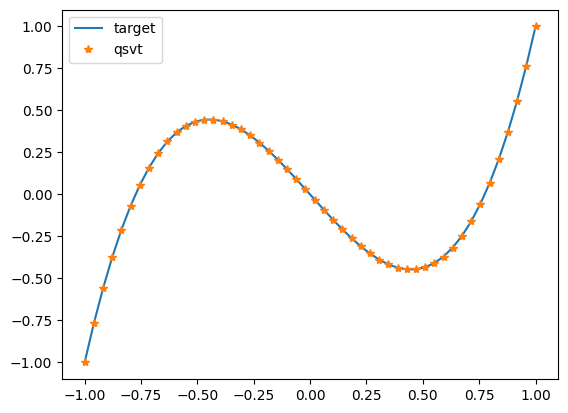

In [8]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt


def target_poly(a):
    return 0.5 * (5 * a**3 - 3 * a)


# pre-optimized angles
angles = [-0.20409113, -0.91173829, 0.91173829, 0.20409113]


def qsvt_output(a):
    # output matrix
    out = qml.matrix(qml.qsvt(a, angles, wires=[0]))
    return out[0, 0]  # top-left entry


a_vals = np.linspace(-1, 1, 50)
qsvt = [np.real(qsvt_output(a)) for a in a_vals]  # neglect small imaginary part
target = [target_poly(a) for a in a_vals]


plt.plot(a_vals, target, label="target")
plt.plot(a_vals, qsvt, "*", label="qsvt")

plt.legend()
plt.show()

It works! 🎉 💃

Quantum signal processing is a result about multiplication of 2x2
matrices, yet it is the core principle underlying the QSVT algorithm. If
you\'ve made it this far, you\'re in great shape for the rest to come 🥇

Transforming matrices encoded in matrices
=========================================

Time to ask another key question: what if instead of encoding a scalar,
we encode an entire matrix $A?$ 🧠 This is trickier since we need to
ensure that the larger operator remains unitary. A way to achieve this
is to use a similar construction as in the scalar case:

$$\begin{aligned}
U(A) = \begin{pmatrix} A & \sqrt{I-A A^\dagger}\\
\sqrt{I-A^\dagger A} & -A^\dagger
\end{pmatrix}.
\end{aligned}$$

This operator is a valid unitary regardless of the form of $A;$ it
doesn\'t even have to be a square matrix. We just need to ensure that
$A$ is properly normalized such that its largest singular value is
bounded by 1.

Any such method of encoding a matrix inside a larger unitary is known as
a **block encoding**. In our construction, the matrix $A$ is encoded in
the top-left block, hence the name. PennyLane supports the
`~pennylane.BlockEncode`{.interpreted-text role="class"} operation that
follows the construction above. Let\'s test it out with an example
encoding first a square matrix:


In [9]:
# square matrix
A = [[0.1, 0.2], [0.3, 0.4]]
U1 = qml.BlockEncode(A, wires=range(2))
print("U(A):")
print(np.round(qml.matrix(U1), 2))

U(A):
[[ 0.1   0.2   0.97 -0.06]
 [ 0.3   0.4  -0.06  0.86]
 [ 0.95 -0.08 -0.1  -0.3 ]
 [-0.08  0.89 -0.2  -0.4 ]]


And also a rectangular matrix


In [10]:
B = [[0.5, -0.5, 0.5]]
U2 = qml.BlockEncode(B, wires=range(2))
print("U(B):")
print(np.round(qml.matrix(U2), 2))

U(B):
[[ 0.5  -0.5   0.5   0.5 ]
 [ 0.83  0.17 -0.17 -0.5 ]
 [ 0.17  0.83  0.17  0.5 ]
 [-0.17  0.17  0.83 -0.5 ]]


Notice that we haven\'t really made a reference to quantum computing;
everything is just linear algebra. Told you so! 😈

Quantum kicks in when we construct circuits that implement a
block-encoding unitary. Arguably the hardest thing about QSVT is
implementing block encodings. We don\'t cover such methods in detail
here, but for reference, a popular approach is to express $A$ as a
linear combination of unitaries and define associated $\text{PREPARE}$
and $\text{SELECT}$ operators. Then the operator

$$U=\text{PREP}^\dagger\cdot\text{SEL}\cdot\text{PREP},$$

is a block-encoding of $A$ up to a constant factor.

Time for a third key question: Can we use the same strategy as in QSP to
polynomially transform a block-encoded matrix? Because that would be
fantastic 😎

For this to be possible, we need to generalize the signal-processing
operator $S(\phi)$ to higher dimensions. This can be done by using a
diagonal unitary where we apply the phase $e^{i\phi}$ to the subspace
determined by the block, and the phase $e^{-i \phi}$ everywhere else.
For example, revisiting the square matrix $A$ in the code above, where
$A$ is encoded in a two-dimensional subspace, the corresponding operator
is

$$\begin{aligned}
\begin{pmatrix} e^{i\phi} & 0 & 0 & 0\\
0 & e^{i\phi} & 0 & 0 \\
0 & 0 & e^{-i\phi} & 0\\
0 & 0 & 0 & e^{-i\phi} \\
\end{pmatrix}.
\end{aligned}$$

These are known as **projector-controlled phase gates**, for which we
use the symbol $\Pi(\phi).$

When $A$ is not square, we have to be careful and define two operators:
one acting on the row subspace and another on the column subspace.
Projector-controlled phase gates are implemented in PennyLane using the
`~pennylane.PCPhase`{.interpreted-text role="class"} operation. Here\'s
a simple example:


In [11]:
dim = 2
phi = np.pi / 2
pcp = qml.PCPhase(phi, dim, wires=range(2))
print("Pi:")
print(np.round(qml.matrix(pcp), 2))

Pi:
[[0.+1.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-1.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.-1.j]]


As you may have guessed, this generalization of QSP does the trick. By
cleverly alternating a block-encoding unitary and the appropriate
projector-controlled phase gates, we can polynomially transform the
encoded matrix. The result is the QSVT algorithm.

Mathematically, when the polynomial degree $d$ is even (number of angles
is $d + 1$), the QSVT algorithm states that

$$\begin{aligned}
\left[\prod_{k=1}^{d/2}\Pi_{\phi_{2k-1}}U(A)^\dagger \tilde{\Pi}_{\phi_{2k}} U(A)\right]\Pi_{\phi_{d+1}}=
\begin{pmatrix} P(A) & *\\
* & *
\end{pmatrix}.
\end{aligned}$$

The tilde is used in the projector-controlled phase gates to distinguish
whether they act on the column or row subspaces. The polynomial
transformation of $A$ is defined in terms of its singular value
decomposition

$$P(A) = \sum_k P(\sigma_k)|w_k\rangle \langle v_k|,$$

where we use braket notation to denote the left and right singular
vectors. For technical reasons, the sequence looks slightly different
when the polynomial degree is odd:

$$\begin{aligned}
\tilde{\Pi}_{\phi_1}\left[\prod_{k=1}^{(d-1)/2}\Pi_{\phi_{2k}}U(A)^\dagger \tilde{\Pi}_{\phi_{2k+1}} U(A)\right]\Pi_{\phi_{d+1}}=
\begin{pmatrix}
P(A) & *\\
* & *
\end{pmatrix}.
\end{aligned}$$

As with QSP, it is possible to use the QSVT sequence to apply any real
polynomial transformation up to degree $d$ when using $d+1$ angles. In
fact, as long as we\'re careful with conventions, we can use the same
angles regardless of the dimensions of $A.$

The QSVT construction is a beautiful result. By using a number of
operations that grows linearly with the degree of the target polynomial,
we can transform the singular values of arbitrary block-encoded matrices
without ever having to actually perform singular value decompositions!
If the block encoding circuits can be implemented in polynomial time in
the number of qubits, the resulting quantum algorithm will also run in
polynomial time. This is very powerful.

In PennyLane, implementing the QSVT transformation is as simple as using
`~.pennylane.qsvt`{.interpreted-text role="func"}. Let\'s revisit our
previous example and transform a matrix according to the same Legendre
polynomial. We\'ll use a diagonal matrix with eigenvalues evenly
distributed between -1 and 1, allowing us to easily check the
transformation.


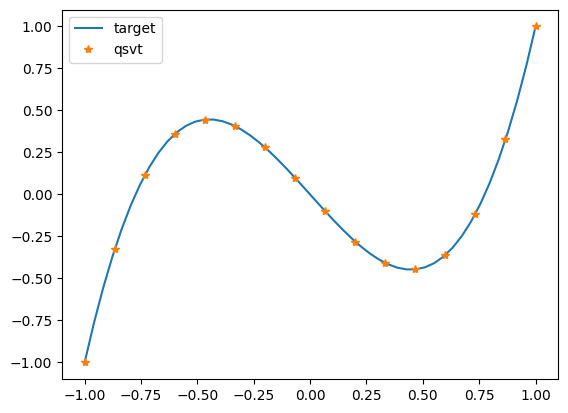

In [14]:
eigvals = np.linspace(-1, 1, 16)
A = np.diag(eigvals)  # 16-dim matrix
wire_order = list(range(5))
U_A = qml.matrix(qml.qsvt, wire_order=wire_order)(A, angles, wires=wire_order)  # block-encoded in 5-qubit system

qsvt_A = np.real(np.diagonal(U_A))[:16]  # retrieve transformed eigenvalues

plt.plot(a_vals, target, label="target")
plt.plot(eigvals, qsvt_A, "*", label="qsvt")

plt.legend()
plt.show()

The `~pennylane.qsvt`{.interpreted-text role="func"} operation is
tailored for use in simulators and employs standard forms for block
encodings and projector-controlled phase shifts. Advanced users can
define their own version of these operators with explicit quantum
circuits, and construct the resulting QSVT algorithm using the
`~pennylane.QSVT`{.interpreted-text role="class"} template.

Final thoughts
==============

The original paper introducing the QSVT algorithm[^1] described a series
of potential applications, notably Hamiltonian simulation and solving
linear systems of equations. QSVT has also been used as a unifying
framework for different quantum algorithms[^2]. One of my favourite uses
of QSVT is to transform a molecular Hamiltonian by a polynomial
approximation of a step function[^3]. This sets large eigenvalues to
zero, effectively performing a projection onto a low-energy subspace.

The PennyLane team is motivated to create tools that can empower
researchers worldwide to develop the innovations that will define the
present and future of quantum computing. We have designed QSVT support
to help you master the concepts and perform rapid prototyping of new
ideas. We look forward to seeing the innovations that will result from
your journey.

References
==========

[^1]: András Gilyén, Yuan Su, Guang Hao Low, Nathan Wiebe, \"Quantum
    singular value transformation and beyond: exponential improvements
    for quantum matrix arithmetics\", [Proceedings of the 51st Annual
    ACM SIGACT Symposium on the Theory of
    Computing](https://dl.acm.org/doi/abs/10.1145/3313276.3316366), 2019

[^2]: John M. Martyn, Zane M. Rossi, Andrew K. Tan, and Isaac L. Chuang,
    \"Grand Unification of Quantum Algorithms\", [PRX Quantum 2,
    040203](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.040203),
    2021

[^3]: Lin, Lin, and Yu Tong, \"Near-optimal ground state preparation\",
    [Quantum 4,
    372](https://quantum-journal.org/papers/q-2020-12-14-372/), 2020


About the author
================
